In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import numpy as np

In [2]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df_spam = pd.read_csv(r'spam.csv')
df_spam['spam']=df_spam['Category'].apply(lambda x: 1 if x=='spam' else 0)

df_spam.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


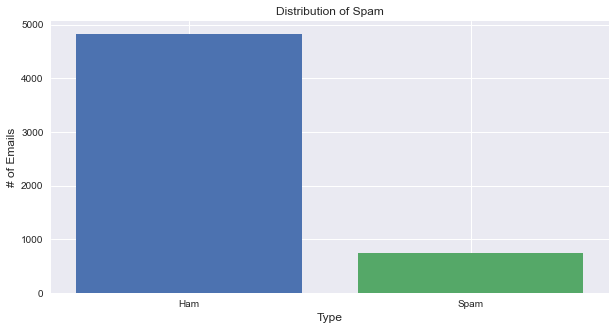

In [4]:
plt.figure(figsize=(10, 5))
plt.bar('Ham', len(df_spam[df_spam['Category']=='ham']))
plt.bar('Spam', len(df_spam[df_spam['Category']=='spam']))

plt.title('Distribution of Spam', size=12)
plt.xlabel('Type', size=12)
plt.ylabel('# of Emails', size=12);

In [5]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    
import re

def normalize(i):
#     for i in data:
    i = i.lower()
    # get rid of urls
    i = re.sub('https?://\S+|www\.\S+', '', i)

    i = re.sub('<[^>]*>', '', i)
    i = re.sub(r'[^\w\s]','', i)
    i = re.sub(r'\$\w*','', i)
    i = re.sub(r'^RT[\s]+','', i)
    i = re.sub(r'http\S+','', i)
    i = re.sub(r'#','', i)

    # get rid of non words and extra spaces
    i = re.sub('\\W', ' ', i)
    i = re.sub('\n', '', i)
    i = re.sub(' +', ' ', i)
    i = re.sub('^ ', '', i)
    i = re.sub(' $', '', i)
    
    return i

In [6]:
df_spam.Message = df_spam.Message.apply(remove_stopwords)
df_spam.Message = df_spam.Message.apply(normalize)
df_spam.head()

,Category,Message,spam
0,ham,go jurong point crazy available bugis great wo...,0
1,ham,ok lar joking wif oni,0
2,spam,free entry wkly comp win fa cup final tkts 21s...,1
3,ham,dun say early hor already say,0
4,ham,nah think goes usf lives around though,0


In [7]:
X = df_spam['Message']
y = df_spam['spam']

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

In [39]:
vocab_size = 100000
embedding_dim = 64
max_length = 768
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [40]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [41]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [ ]:
X_train_bert = get_sentence_embeding(X_train)
X_test_bert = get_sentence_embeding(X_test)

In [ ]:
X_train_bert.shape

In [ ]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

# Build Model

## LSTM

In [38]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size+1,embedding_dim,input_length=max_length),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
tf.keras.layers.Dropout(0.1, name="dropout"),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(1, activation='softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 768, 64)           64000064  
                                                                 
 bidirectional_8 (Bidirectio  (None, 768, 128)         66048     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 768, 128)          0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 64,107,393
Trainable params: 64,107,393


In [34]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=METRICS)

In [35]:
# history = model.fit(X_train_bert, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])
history = model.fit(X_train_bert, y_train, epochs=10,)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_2/embedding_2/embedding_lookup' defined at (most recent call last):
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 418, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/sc/m38hzk_90cn6t0363cr74ny40000gn/T/ipykernel_26039/2426813912.py", line 1, in <cell line: 1>
      history = model.fit(X_train_bert, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/keras/layers/core/embedding.py", line 199, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_2/embedding_2/embedding_lookup'
indices[22,85] = -1 is not in [0, 1000001)
	 [[{{node sequential_2/embedding_2/embedding_lookup}}]] [Op:__inference_train_function_87044]

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

print("---Test Set Results---")
print("Accuracy: {}".format(accuracy_score(y_test, binary_predictions)))
print(classification_report(y_test, binary_predictions))

In [ ]:
import seaborn as sns


matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

Just using a dense layer is not good enough as the scores are acceptable but not as high as the baseline model.